# Imports

https://discuss.pytorch.org/t/loaded-model-returns-different-predictions/77588/2

https://discuss.pytorch.org/t/model-shows-different-predictions-after-training-without-weight-update/75877/5



In [ ]:
from google.colab import drive
import os
%load_ext autoreload
%autoreload 2

drive.mount('/content/gdrive', force_remount=True)
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/')

Mounted at /content/gdrive


In [ ]:
!pip install antspyx

     |████████████████████████████████| 300.4 MB 8.8 kB/s 
     |████████████████████████████████| 64 kB 3.7 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sp
from joblib import dump, load
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [ ]:
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/src/data_preparation/')
# import mri_metadata_preparation

In [ ]:
import os
import sys
import time
import random
import argparse
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

from mri_augmentation import *
sys.path.append("./../utils")
from base_mri import *
from utils import *

def generate_mri_dataset_reference(mri_reference_path,
                                output_path,
                                orientation = 'coronal',
                                orientation_slice = 50,
                                num_sampled_images = 5,
                                sampling_range = 3,
                                num_rotations = 3,
                                save_reference_file = True):

    '''
    Execute MRI metadata preparation for training the deep learning model. The final image will be generated only during training/test/validation step.

    Main Steps:

    - Select orientation of training.
    
    - Select slice indication.

    - Executes Data Augmentation (optional) generating more images based on rotation and flipping. 

    Parameters
    ----------
 
    mri_reference_path: path of the processed MRI reference file.
    
    output_path: path to save the metadata reference file.
    
    orientation: Orientation to slice the image. Values can be "coronal", "sagittal" or "axial".
    
    orientation_slice: Mark to slice the 3D image. Values range from 0 to 100. TODO: fix future bug if sampling_range is outside of the image.
    
    num_sampled_images: Number of images to sample.
    
    sampling_range: Range to sample new images from original 3D image, with reference to the orientation_slice.

    num_rotations: Number of different rotations to augment original image.

    save_reference_file: Flag to save the reference file or not.
    
    '''

    df_mri_reference = pd.read_csv(mri_reference_path)

    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)

    df_mri_dataset = df_mri_reference.query("ORIENTATION == @orientation and VALID_IMAGE == True")
    df_mri_dataset['MAIN_SLICE'] = orientation_slice
    images= df_mri_reference['IMAGE_DATA_ID'].unique().tolist()
    
    print("Creating augmented samples...")
    df_samples = generate_augmented_slices(orientation_slice,sampling_range,num_sampled_images,preprocessed_images = images)
    df_mri_dataset = df_mri_dataset.merge(df_samples,on=['IMAGE_DATA_ID','SLICE'],how='inner').reset_index(drop=True)
    df_mri_dataset['SLICE_ID'] = df_mri_dataset['IMAGE_DATA_ID'] + '_' + df_mri_dataset['SLICE'].astype(str)
    
    if num_rotations > 0:
        print("Creating 2d image rotations...")
        df_samples_rot = generate_augmented_rotations(num_rotations=num_rotations,preprocessed_images=df_mri_dataset['SLICE_ID'])
        df_mri_dataset = df_mri_dataset.merge(df_samples_rot,on='SLICE_ID')

    print("Creating final reference file for prepared images...")
    if save_reference_file:
        now = datetime.now().strftime("%Y%m%d_%H%M")
        reference_file_name = 'PROCESSED_MRI_REFERENCE_' + orientation + '_' + str(orientation_slice) + '_samples_around_slice_' + str(num_sampled_images) +'_num_rotations_' + str(num_rotations) + '_'+ now + '.csv'
        df_mri_dataset.to_csv(output_path+reference_file_name,index=False)
        print("Processed MRI reference file saved at:",output_path+reference_file_name)
    return df_mri_dataset

def generate_augmented_slices(orientation_slice,sampling_range,num_sampled_images,preprocessed_images):
    random.seed(a=None, version=2)
    sampling_population = list(set(range(orientation_slice-sampling_range,orientation_slice+sampling_range+1)) - set([orientation_slice]))
    samples = [(img,random.sample(population= sampling_population,k=num_sampled_images)+[orientation_slice]) for img in preprocessed_images]
    df_samples  = pd.DataFrame(samples,columns=['IMAGE_DATA_ID','SLICE'])
    return df_samples.explode('SLICE').reset_index(drop=True)

def generate_augmented_rotations(num_rotations,preprocessed_images):
    random.seed(a=None, version=2)
    samples = [(img,random.sample(population= list(np.arange(-15,16,2)) ,k=num_rotations) + [0]) for img in preprocessed_images]
    df_samples  = pd.DataFrame(samples,columns=['SLICE_ID','ROTATION_ANGLE'])
    return df_samples.explode('ROTATION_ANGLE').reset_index(drop=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings("ignore")

from scipy import ndimage
from torch.utils.data import Dataset
from torchvision import transforms as T

import numpy as np

class MRIDataset(Dataset):

     '''
     Builds a dataset loader component for PyTorch with the MRIs based on the filepath.
     '''

     def __init__(self, reference_table,target_column = 'MACRO_GROUP'):
          
          '''
          Initialization of the component

          Parameters
          ----------

          reference_table: Pandas DataFrame containing the reference for the subjects, images and their labels

          '''
          self.target_column = target_column
          self.reference_table = reference_table
          # self.transform_train = self.T.Compose([
          #      transforms.RandomCrop(32, padding=4),
          #      transforms.RandomRotation(degrees=15),
          #      transforms.ToTensor(),
          #      transforms.Normalize(rgb_mean, rgb_std),
          # ])
     def __len__(self):
          'Denotes the total number of samples'
          return self.reference_table.shape[0]

     def __getitem__(self, index):
          'Generates one sample of data'
          
          # Select sample
          sample = self.reference_table.iloc[index]

          # Load data and get label
          X = np.load(sample['IMAGE_PATH'])['arr_0']

          if 'ROTATION_ANGLE' in sample.index and sample['ROTATION_ANGLE'] != 0:
               X = ndimage.rotate(X, sample['ROTATION_ANGLE'], reshape=False)
                         
          X = X/X.max()
          y = sample[self.target_column]
          return X, y


In [ ]:
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/src/model_training/')
# import mri_metadata_preparation

In [ ]:
import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

class SuperShallowCNN(Module):
    def __init__(self):
        super(SuperShallowCNN, self).__init__()
        self.features = Sequential(
            Conv2d(in_channels =1, out_channels =8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(num_features=8),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =8, out_channels =16, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=16),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =16, out_channels =32, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=32),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =32, out_channels =64, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=64),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =64, out_channels =128, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True)
        )
        self.avgpool = AdaptiveAvgPool2d(output_size=(4, 4))
        self.classifier = Sequential(
            # Remember changing the x.view() number as well. It needs to be flattenend!
            Linear(in_features=128*4*4, out_features=128, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=128, out_features=64, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            # Linear(in_features=64, out_features=64, bias=True),
            # ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=64, out_features=1, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.size())
        x = self.avgpool(x)
        # print(x.size())

        # flattenning 
        x = x.view(-1,128*4*4)
        # print(x.size())
        logits = self.classifier(x)
        # print(logits.size())
        return logits

# nnn = SuperShallowCNN()
# nnn.forward(x)

In [ ]:
import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

class NeuralNetwork(Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.features = Sequential(
            Conv2d(in_channels =1, out_channels =8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(num_features=8),
            ReLU(inplace=True),
            MaxPool2d(2,2),

            Conv2d(in_channels =8, out_channels =16, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=16),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =16, out_channels =32, kernel_size=3, stride=1, padding=0),
            BatchNorm2d(num_features=32),
            ReLU(inplace=True),
            MaxPool2d(2,2),
            
            Conv2d(in_channels =32, out_channels =64, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True)
        )
        self.avgpool = AdaptiveAvgPool2d(output_size=(8, 8))
        self.classifier = Sequential(
            # Remember changing the x.view() number as well. It needs to be flattenend!
            Linear(in_features=64*8*8, out_features=512, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=512, out_features=512, bias=True),
            ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            # Linear(in_features=512, out_features=512, bias=True),
            # ReLU(inplace=True),
            # Dropout(p=0.5, inplace=False),
            Linear(in_features=512, out_features=1, bias=True)

        )

    def forward(self, x):
        x = self.features(x)
        # print(x.size())
        x = self.avgpool(x)
        # print(x.size())
        # flattenning 
        x = x.view(-1,64*8*8)
        # print(x.size())
        logits = self.classifier(x)
        # print(logits.size())
        return logits

In [ ]:
import torchvision.models as models

def adapt_vgg(vgg):
    vgg.features[0] = Conv2d(1,64, 3, stride=1,padding=1)
    return vgg

vgg11 = adapt_vgg(models.vgg11())
vgg11_bn = adapt_vgg(models.vgg11_bn())
vgg13 = adapt_vgg(models.vgg13())
vgg13_bn = adapt_vgg(models.vgg13_bn())

In [ ]:
import time
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

import torch
# from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCEWithLogitsLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, AdaptiveAvgPool2d
from torch.optim import Adam, SGD,RMSprop

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models

from mri_dataset import MRIDataset
from mri_dataset_generation import generate_mri_dataset_reference

import sys
sys.path.append("./../data_preparation")
from train_test_split import train_test_split_by_subject

# sys.path.append("./../models")
# from neural_network import NeuralNetwork, SuperShallowCNN,create_adapted_vgg11

# %load_ext autoreload
# %autoreload 2

# Defining global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

def run_mris_experiments(orientation_and_slices = [('coronal',list(range(45,56)))],
                          num_repeats = 3,
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    results = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for ii in range(1,num_repeats+1):
            for slice in slices:
                print("\n--------------------------------------------------------------------")
                print("--------------------------------------------------------------------")
                print(f"Running {orientation} - slice:{slice} with no data augmentation.")
                print("--------------------------------------------------------------------")
                print("--------------------------------------------------------------------\n")
                mri_config['slice'] = slice
                df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                    output_path = mri_config['output_path'],
                                    orientation = mri_config['orientation'],
                                    orientation_slice = mri_config['slice'],
                                    num_sampled_images = mri_config['num_samples'],
                                    sampling_range = mri_config['sampling_range'],
                                    num_rotations = mri_config['num_rotations'],
                                    save_reference_file = False)
                run_result = run_cnn_experiment(model = model,
                            model_name = 'cnn_'+orientation+str(slice)+str(ii),
                            classes = classes,
                            mri_reference = df_ref,
                            run_test = False,
                            compute_predictions = False,
                            prediction_dataset_path = '',
                            model_path = '',
                            additional_experiment_params = additional_experiment_params)
                run_result['orientation'] = orientation
                run_result['slice'] = slice
                run_result['run'] = ii
                run_result['RUN_ID'] = orientation+str(slice)+str(ii)
                results.append(run_result)

    df_results = pd.concat(results)
    if save_path != '' and save_path is not None:
        df_results.to_csv(save_path,index=False)
    return df_results


def run_experiments_for_ensemble(orientation_and_slices = [('coronal',list(range(45,56)))],
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    predictions = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for slice in slices:
            print("\n--------------------------------------------------------------------")
            print("--------------------------------------------------------------------")
            print(f"Running {orientation} - slice:{slice} with no data augmentation.")
            print("--------------------------------------------------------------------")
            print("--------------------------------------------------------------------\n")
            mri_config['slice'] = slice
            df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                output_path = mri_config['output_path'],
                                orientation = mri_config['orientation'],
                                orientation_slice = mri_config['slice'],
                                num_sampled_images = mri_config['num_samples'],
                                sampling_range = mri_config['sampling_range'],
                                num_rotations = mri_config['num_rotations'],
                                save_reference_file = False)
            prediction,_ = run_cnn_experiment(model = model,
                        model_name = 'cnn_'+orientation+str(slice),
                        classes = classes,
                        mri_reference = df_ref,
                        run_test = False,
                        compute_predictions = True,
                        prediction_dataset_path = '',
                        model_path = '',
                        additional_experiment_params = additional_experiment_params)
            prediction['orientation'] = orientation
            prediction['slice'] = slice
            prediction['RUN_ID'] = orientation+str(slice)
            predictions.append(prediction)

    df_predictions = pd.concat(predictions)
    # TODO: pivot table to make RUN_ID turn into columns for the prediction scores
    if save_path != '' and save_path is not None:
        df_predictions.to_csv(save_path,index=False)
    return df_predictions


def run_cnn_experiment(model = 'vgg11',
                       model_name = 'vgg11_2048_2048',
                       classes = ['AD','CN'],
                       mri_reference = '',
                       run_test = False,
                       compute_predictions = False,
                       prediction_dataset_path = '',
                       model_path = '',
                       additional_experiment_params = None):
    '''
    Run the MRI classification for AD or CN.

    Parameters
    ----------

    model: Neural network to be trained. Can be 'vgg11' or 'shallow'.
    
    model_name: Name to save the trained model.
    
    classes: classes to filter the dataset. options can be ['AD','CN','MCI']

    mri_reference: Path or file of the MRI reference that will be used to filter the validation/test sets and classes. 

    prediction_dataset_path: '/content/gdrive/MyDrive/Lucas_Thimoteo/mri/processed/',
    
    model_path: Path to save the trained model.
    
    additional_experiment_params: dictionary containing some experiments parameters such as lr (learning rate), batch_size and optimizer.

    '''

    if additional_experiment_params is None:
        additional_experiment_params = {'lr':0.0001,
                             'batch_size':16,
                             'optimizer':'adam',
                             'max_epochs':100,
                             'early_stop':10,
                             'prediction_threshold':0.5}
    if type(mri_reference) == str:
        df_mri_reference = pd.read_csv(mri_reference)
    else:
        df_mri_reference = mri_reference
    
    if type(model) == str:
        model = load_model(model)
    model_name = model_name + datetime.now().strftime("%m%d%Y_%H%M")
    
    optimizer,criterion,prepared_data = setup_experiment(model,classes,df_mri_reference,additional_experiment_params)

    train_metrics,validation_metrics = train(train_dataloader=prepared_data['train_dataloader'],
        validation_dataloader=prepared_data['validation_dataloader'],
        model=model,
        loss_fn=criterion,
        optimizer=optimizer,
        max_epochs=additional_experiment_params['max_epochs'],
        early_stopping_epochs=additional_experiment_params['early_stop'],
        model_name = model_name,
        model_path=model_path)
    
    cols = train_metrics.keys()
    train_cols = ['train_'+x for x in cols]
    df_results = pd.DataFrame([train_metrics])
    df_results.columns = train_cols
    
    validation_cols = ['validation_'+x for x in cols]
    for col,value in zip(validation_cols,validation_metrics.values()):
        df_results[col] = [value]

    if run_test:
        # model.load_state_dict(torch.load(model_path + model_name+'.pth'))
        model.eval()
        test_metrics = test(dataloader=prepared_data['test_dataloader'],
            model=model,
            loss_fn=criterion,
            return_predictions=False,
            compute_metrics=True)
        test_cols = ['test_'+x for x in cols]
        for col,value in zip(test_cols,test_metrics.values()):
            df_results[col] = value
            
    if compute_predictions:
        df_predictions = compute_predictions_for_dataset(prepared_data,model,criterion,threshold = additional_experiment_params['prediction_threshold'])
        if prediction_dataset_path is not None and prediction_dataset_path != '':
            df_predictions.to_csv(prediction_dataset_path + "PREDICTED_MRI_REFERENCE.csv",index=False)
        return df_predictions,df_results
    return df_results

def setup_experiment(model,classes,df_mri_reference,additional_experiment_params):

    print("Setting up experiment parameters...")

    if additional_experiment_params['optimizer'] == 'adam':
        optimizer = Adam(model.parameters(), lr=additional_experiment_params['lr'])
    elif additional_experiment_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(model.parameters(), lr=additional_experiment_params['lr'])
    else:
        optimizer = SGD(model.parameters(), lr=additional_experiment_params['lr'])

    dataset_params = {'batch_size': additional_experiment_params['batch_size'],
            'shuffle': False,
            'num_workers': 4,
            'pin_memory':True}
    
    df_train_reference, df_validation_reference, df_test_reference = return_sets(df_mri_reference,classes)

    # Defining Dataset Generators
    training_set = MRIDataset(reference_table = df_train_reference)
    train_dataloader = DataLoader(training_set, **dataset_params)

    validation_set = MRIDataset(reference_table = df_validation_reference)
    validation_dataloader = DataLoader(validation_set, **dataset_params)

    test_set = MRIDataset(reference_table = df_test_reference)
    test_dataloader = DataLoader(test_set, **dataset_params)
    prepared_data = {
        'train_dataloader':train_dataloader,
        'validation_dataloader':validation_dataloader,
        'test_dataloader':test_dataloader,
        'df_train_reference':df_train_reference,
        'df_validation_reference':df_validation_reference,
        'df_test_reference':df_test_reference
    }

    # pos_weight = torch.ones([1]) * (neg_class/pos_class)
    criterion = BCEWithLogitsLoss()
    criterion = criterion.to(device)

    return optimizer,criterion,prepared_data

def return_sets(df_mri_reference,classes):
    if set(classes) == set(['AD','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','CN']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'CN','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 1
    elif set(classes) == set(['MCI','AD']):
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'MCI','MACRO_GROUP'] = 0
        df_mri_reference.loc[df_mri_reference['MACRO_GROUP'] == 'AD','MACRO_GROUP'] = 1

    df_mri_reference = df_mri_reference.loc[df_mri_reference['MACRO_GROUP'].isin([0,1]),:]

    filter_query = "DATASET == 'set' and SLICE == MAIN_SLICE"
    if 'ROTATION_ANGLE' in df_mri_reference.columns:
      filter_query = filter_query + " and (ROTATION_ANGLE == 0 or ROTATION_ANGLE == '0')"

    df_validation_reference = df_mri_reference.query(filter_query.replace('set','validation'))
    df_test_reference = df_mri_reference.query(filter_query.replace('set','test'))
    df_train_reference = df_mri_reference.query("DATASET not in ('validation','test')")

    print("Train size:",df_train_reference.shape[0])
    print("Validation size:",df_validation_reference.shape[0])
    print("Test size:",df_test_reference.shape[0])
    return df_train_reference, df_validation_reference, df_test_reference

def compute_predictions_for_dataset(prepared_data, model,criterion,threshold=0.5):

    loaders = [
        prepared_data['train_dataloader'],
        prepared_data['validation_dataloader'],
        prepared_data['test_dataloader']
    ]

    datasets = [
        prepared_data['df_train_reference'],
        prepared_data['df_validation_reference'],
        prepared_data['df_test_reference'],
    ]
    dataset_types = ['train','validation','test']

    print("Saving predictions from trained model...")
    for dataset_type,data_loader,df in zip(dataset_types,loaders,datasets):
        print(f'Computing Predictions for {dataset_type} set.')
        print('dataset size:',df.shape)
        predict_probs,test_metrics = test(dataloader=data_loader,
        model=model,
        loss_fn=criterion,
        compute_metrics=False,
        return_predictions=True)
        predicted_labels = predict_probs >= threshold
        df['CNN_LABEL' ] = predicted_labels
        df['CNN_SCORE' ] = predict_probs

    return pd.concat(datasets)

def load_model(model_type='shallow'):
    print("Loading untrained model...")
    if model_type == 'vgg11':
        vgg = adapt_vgg(models.vgg11())
        model = vgg.to(device)
    
    elif model_type == 'vgg11_bn':
        vgg11_bn = adapt_vgg(models.vgg11_bn())
        model = vgg11_bn.to(device)

    elif model_type == 'vgg13_bn':
        vgg13_bn = adapt_vgg(models.vgg13_bn())
        model = vgg13_bn.to(device)

    elif model_type == 'vgg16_bn':
        vgg16_bn = adapt_vgg(models.vgg16_bn())
        model = vgg16_bn.to(device)

    elif model_type == 'vgg19_bn':
        vgg19_bn = adapt_vgg(models.vgg19_bn())
        model = vgg19_bn.to(device)
    
    elif model_type == 'resnet34':
        resnet34 = adapt_resnet(models.resnet34(),linear_features=512)
        model = resnet34.to(device)

    elif model_type == 'resnet50':
        resnet50 = adapt_resnet(models.resnet50(),linear_features=2048)
        model = resnet50.to(device)
    
    elif model_type == 'resnet101':
        resnet101 = adapt_resnet(models.resnet101(),linear_features=2048)
        model = resnet101.to(device)
    
    elif model_type == 'shallow_cnn':
        custom_nn = NeuralNetwork()
        model = custom_nn.to(device)
    elif model_type == 'super_shallow_cnn':
        custom_nn = SuperShallowCNN()
        model = custom_nn.to(device)
    else:
        model = model.to(device)

    print(model)
    print('')
    count_trainable_parameters(model)
    return model

def adapt_resnet(resnet,linear_features = 512):
    resnet.conv1 = Conv2d(1,64, 7, stride=2,padding=3)
    resnet.fc = Sequential(
    Linear(in_features=linear_features, out_features=1000, bias=True),
    ReLU(inplace=True),
    Dropout(p=0.5, inplace=False),
    Linear(in_features=1000, out_features=1, bias=True)
    )
    return resnet
    
def adapt_vgg(vgg):
    vgg.features[0] = Conv2d(1,64, 3, stride=1,padding=1)
    vgg.classifier[-1] = Linear(in_features=4096, out_features=1,bias=True)
    return vgg

def train(train_dataloader,
            validation_dataloader, 
            model, 
            loss_fn, 
            optimizer,
            max_epochs=100,
            early_stopping_epochs = 10,
            model_name = 'experiment',
            model_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/models/'):

    train_losses = []
    validation_losses = []
    train_aucs = []
    validation_aucs = []
    best_epoch = 0
    best_validation_auc = 0
    early_stopping_marker = 0
    best_model_params = model.state_dict()
    best_validation_metrics = None
    best_validation_loss = None
    for epoch in range(max_epochs):
        t0 = time.time()
        
        print('\n---------------------------------------------------------------------')
        print(f'Running Epoch {epoch + 1} of  {max_epochs}')
        
        train_loss,train_metrics = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        validation_loss, validation_metrics = validate_one_epoch(validation_dataloader, model, loss_fn, optimizer)
        
        print_metrics(train_metrics,train_loss,validation_metrics,validation_loss)
        print('\nEpoch {} took'.format(epoch+1),'%3.2f seconds' % (time.time() - t0))
        print('---------------------------------------------------------------------')
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_aucs.append(train_metrics['auc'])
        validation_aucs.append(validation_metrics['auc'])

        if best_validation_auc >= validation_metrics['auc']:
            early_stopping_marker += 1
        else:
            best_epoch = epoch+1
            best_validation_auc = validation_metrics['auc']
            early_stopping_marker = 0
            best_model_params = model.state_dict()
            best_validation_metrics = validation_metrics
            best_validation_loss = validation_loss
            best_train_metrics = train_metrics
            best_train_loss = train_loss

            print('Best validation AUC so far: %1.4f' % best_validation_metrics['auc'])
        
        if early_stopping_epochs > 0:
            if early_stopping_marker == early_stopping_epochs:
                print("\nExiting training... It hit early stopping criteria of:",early_stopping_epochs,'epochs')
                print("Saving model at:",model_path)
                # torch.save(best_model_params, model_path + model_name + '.pth')
                break

        if (best_epoch) == max_epochs:
            print("Saving model at:",model_path,'\n')
            # torch.save(best_model_params, model_path + model_name + '.pth')

    plot_metric(metric='Loss',train_metric=train_losses,validation_metric= validation_losses)    
    plot_metric(metric='AUC',train_metric=train_aucs,validation_metric= validation_aucs)    
    print('\n-------------------------------')
    print(f"Best metrics for validation set on Epoch {best_epoch}:")
    print_metrics(best_validation_metrics,best_validation_loss)
    print('-------------------------------\n')
    
    return best_train_metrics,best_validation_metrics

def plot_metric(metric,train_metric, validation_metric):
    plt.plot(train_metric, label=f'Train {metric}')
    plt.plot(validation_metric, label=f'Validation {metric}')
    plt.legend()
    plt.title(f"Train vs Validation {metric}")
    plt.show()

def test(dataloader,model,loss_fn,compute_metrics = True, return_predictions = False,dataset_type = 'test'):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)
    y_predict_probabilities = torch.Tensor().to(device)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.view(-1,1, 100,100)
            y = y.view(-1,1)
            # y = one_hot(y, num_classes)
            # y = y.view(-1,num_classes)
            y_pred = model(X)
            y = y.type_as(y_pred)

            test_loss += loss_fn(y_pred, y).item()
            true_labels = torch.cat((true_labels,y),0)
            predicted_labels = torch.cat((predicted_labels,y_pred),0)
            if return_predictions:
                y_predict_proba = torch.sigmoid(y_pred)
                y_predict_probabilities = torch.cat((y_predict_probabilities,y_predict_proba),0)

        test_metrics = None
        if compute_metrics:
            test_loss /= size
            print(f"Performance for {dataset_type} set:")
            test_metrics = compute_metrics_binary(y_true = true_labels, y_pred = predicted_labels,threshold = 0.5,verbose=0)
            print_metrics(test_metrics,test_loss,validation_metrics = None)

        if return_predictions:
            return y_predict_probabilities.cpu().detach().numpy().ravel(),test_metrics
        
        return test_metrics

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.view(-1,1, 100,100)
        y = y.view(-1,1)
        # y = one_hot(y, num_classes)
        # y = y.view(-1,num_classes)

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # Compute prediction error
        y_pred = model(X)
        y = y.type_as(y_pred)
        loss = loss_fn(y_pred, y)

        # backpropagation 
        loss.backward()

        # update optimizer
        optimizer.step()
        loss = loss.item() 
        running_loss += loss 
        true_labels = torch.cat((true_labels,y),0)
        predicted_labels = torch.cat((predicted_labels,y_pred),0)
    train_metrics = compute_metrics_binary(y_pred = predicted_labels,y_true = true_labels,threshold = 0.5,verbose=0)
    running_loss = running_loss/size
    return running_loss, train_metrics

def validate_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0
    true_labels = torch.Tensor().to(device)
    predicted_labels = torch.Tensor().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            X = X.view(-1,1, 100,100)
            y = y.view(-1,1)
            # y = one_hot(y, num_classes)
            # y = y.view(-1,num_classes)

            y_pred = model(X)
            y = y.type_as(y_pred)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss = loss.item()
            
            running_loss += loss    
            true_labels = torch.cat((true_labels,y),0)
            predicted_labels = torch.cat((predicted_labels,y_pred),0)

        validation_metrics = compute_metrics_binary(y_pred = predicted_labels,y_true = true_labels,threshold = 0.5,verbose=0)
        running_loss = running_loss/size
        
        return running_loss, validation_metrics

def compute_metrics_binary(y_true:torch.Tensor, y_pred:torch.Tensor, y_pred_proba:torch.Tensor = None,threshold = 0.5,verbose=0):
    
    if y_pred_proba is None:
        y_pred_proba = torch.sigmoid(y_pred)
    y_pred_label = y_pred_proba
    y_pred_label[y_pred_proba >= threshold] = 1
    y_pred_label[y_pred_proba < threshold] = 0
    
    y_true = y_true.cpu().detach().numpy()
    y_pred_label = y_pred_label.cpu().detach().numpy()
    y_pred_proba = y_pred_proba.cpu().detach().numpy()

    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_label)
    f1score = f1_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    conf_mat = confusion_matrix(y_true, y_pred_label)

    if verbose > 0:
        print('----------------')
        print("Total samples in batch:",y_true.shape)
        print("AUC:       %1.3f" % auc)
        print("Accuracy:  %1.3f" % accuracy)
        print("F1:        %1.3f" % f1score)
        print("Precision: %1.3f" % precision)
        print("Recall:    %1.3f" % recall)
        print("Confusion Matrix: \n", conf_mat)
        print('----------------')
    metrics = {
        'auc':auc,
        'accuracy':accuracy,
        'f1score':f1score,
        'precision':precision,
        'recall':recall,
        'conf_mat':conf_mat
    }
    return metrics

def print_metrics(train_metrics,train_loss,validation_metrics = None,validation_loss = None):
    
    if validation_metrics is not None:

        print(f"Loss::      Train {train_loss:.4f}      Validation {validation_loss:.4f}")
        print(f"AUC::       Train {train_metrics['auc']:.4f}      Validation {validation_metrics['auc']:.4f}")
        print(f"Accuracy::  Train {train_metrics['accuracy']:.4f}      Validation {validation_metrics['accuracy']:.4f}")
        print(f"F1::        Train {train_metrics['f1score']:.4f}      Validation {validation_metrics['f1score']:.4f}")
        print(f"Precision:: Train {train_metrics['precision']:.4f}      Validation {validation_metrics['precision']:.4f}")
        print(f"Recall::    Train {train_metrics['recall']:.4f}      Validation {validation_metrics['recall']:.4f}")
        print("Validation Confusion Matrix:\n", validation_metrics['conf_mat'])
    else:
        print(f"Loss::      {train_loss:.4f}")
        print(f"AUC::       {train_metrics['auc']:.4f}")
        print(f"Accuracy::  {train_metrics['accuracy']:.4f}")
        print(f"F1::        {train_metrics['f1score']:.4f}")
        print(f"Precision:: {train_metrics['precision']:.4f}")
        print(f"Recall::    {train_metrics['recall']:.4f}")
        print("Confusion Matrix:\n", train_metrics['conf_mat'])

def count_trainable_parameters(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    print("Total number of trainable parameters:",pp)

Using cuda device


In [ ]:
def run_experiments_for_ensemble(orientation_and_slices = [('coronal',list(range(45,56)))],
                          model='shallow_cnn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = ''):

    predictions = []
    for orientation,slices in orientation_and_slices:
        mri_config['orientation'] = orientation
        for slice in slices:
            print("\n--------------------------------------------------------------------")
            print("--------------------------------------------------------------------")
            print(f"Running {orientation} - slice:{slice} with no data augmentation.")
            print("--------------------------------------------------------------------")
            print("--------------------------------------------------------------------\n")
            mri_config['slice'] = slice
            df_ref = generate_mri_dataset_reference(mri_reference_path = mri_config['mri_reference'],
                                output_path = mri_config['output_path'],
                                orientation = mri_config['orientation'],
                                orientation_slice = mri_config['slice'],
                                num_sampled_images = mri_config['num_samples'],
                                sampling_range = mri_config['sampling_range'],
                                num_rotations = mri_config['num_rotations'],
                                save_reference_file = False)
            prediction,_ = run_cnn_experiment(model = model,
                        model_name = 'cnn_'+orientation+str(slice),
                        classes = classes,
                        mri_reference = df_ref,
                        run_test = False,
                        compute_predictions = True,
                        prediction_dataset_path = '',
                        model_path = '',
                        additional_experiment_params = additional_experiment_params)
            prediction['orientation'] = orientation
            prediction['slice'] = slice
            prediction['RUN_ID'] = orientation+str(slice)
            predictions.append(prediction)

    df_predictions = pd.concat(predictions)
    # TODO: pivot table to make RUN_ID turn into columns for the prediction scores
    if save_path != '' and save_path is not None:
        df_predictions.to_csv(save_path,index=False)
    return df_predictions

# Running CNNs


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:43 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

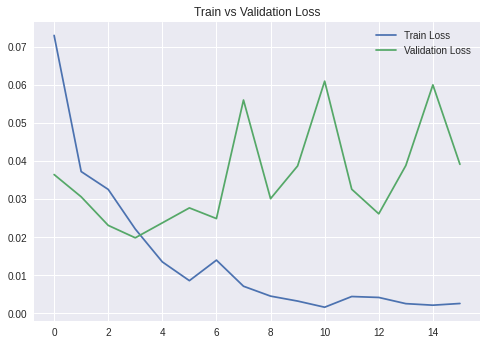

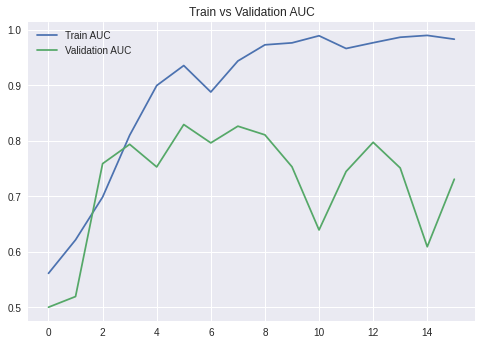


-------------------------------
Best metrics for validation set on Epoch 6:
Loss::      0.0277
AUC::       0.8293
Accuracy::  0.8992
F1::        0.7534
Precision:: 0.8088
Recall::    0.7051
Confusion Matrix:
 [[266  13]
 [ 23  55]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1713, 14)
Computing Predictions for validation set.
dataset size: (357, 14)
Computing Predictions for test set.
dataset size: (349, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running sagittal - slice:26 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_s

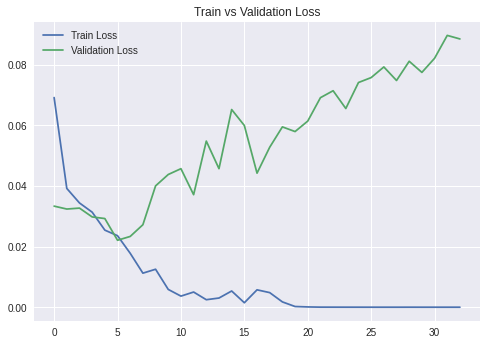

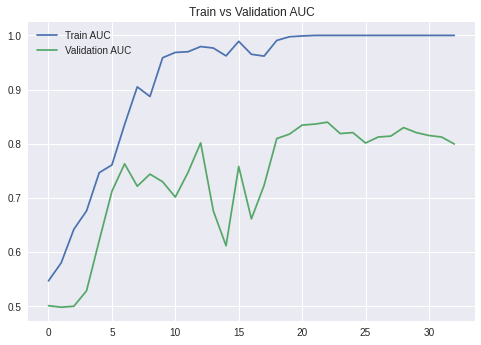


-------------------------------
Best metrics for validation set on Epoch 23:
Loss::      0.0714
AUC::       0.8398
Accuracy::  0.8796
F1::        0.7362
Precision:: 0.7059
Recall::    0.7692
Confusion Matrix:
 [[254  25]
 [ 18  60]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1713, 14)
Computing Predictions for validation set.
dataset size: (357, 14)
Computing Predictions for test set.
dataset size: (349, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:23 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_siz

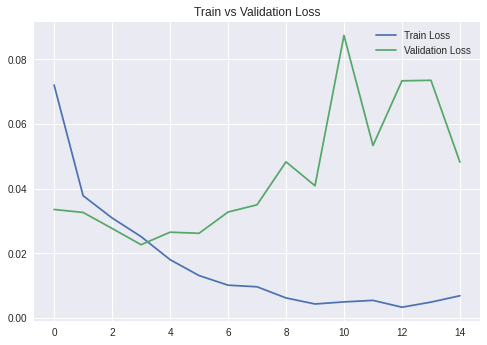

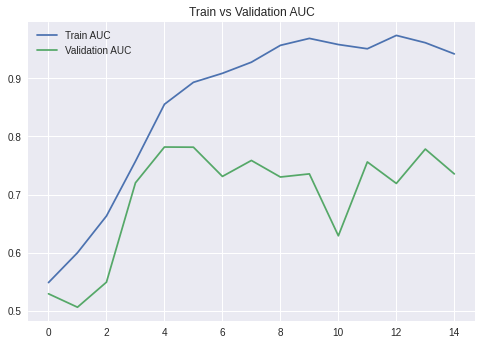


-------------------------------
Best metrics for validation set on Epoch 5:
Loss::      0.0265
AUC::       0.7818
Accuracy::  0.8683
F1::        0.6759
Precision:: 0.7313
Recall::    0.6282
Confusion Matrix:
 [[261  18]
 [ 29  49]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1713, 14)
Computing Predictions for validation set.
dataset size: (357, 14)
Computing Predictions for test set.
dataset size: (349, 14)


,SUBJECT,IMAGE_DATA_ID,ORIENTATION,SLICE,VALID_IMAGE,GROUP,MACRO_GROUP,SEX,AGE,IMAGE_PATH,ORIGINAL_IMAGE_PATH,DATASET,MAIN_SLICE,SLICE_ID,CNN_LABEL,CNN_SCORE,orientation,slice,RUN_ID
5,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,False,2.861137e-09,coronal,43,coronal43
8,941_S_4255,I261061,coronal,43,True,CN,0,M,73,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I261061_43,False,1.159173e-06,coronal,43,coronal43
11,941_S_4066,I241396,coronal,43,True,CN,0,F,79,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I241396_43,False,3.679687e-05,coronal,43,coronal43
14,153_S_5267,I384777,coronal,43,True,SMC,0,F,66,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I384777_43,False,3.444817e-07,coronal,43,coronal43
18,153_S_4372,I270067,coronal,43,True,CN,0,F,70,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I270067_43,False,1.412286e-06,coronal,43,coronal43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3711,002_S_4213,I362924,axial,23,True,CN,0,F,79,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I362924_23,False,2.405035e-05,axial,23,axial23
3723,002_S_0413,I649030,axial,23,True,CN,0,F,85,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I649030_23,False,3.977747e-09,axial,23,axial23
3724,002_S_0413,I312701,axial,23,True,CN,0,F,82,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I312701_23,False,1.374749e-09,axial,23,axial23
3725,002_S_0413,I424741,axial,23,True,CN,0,F,84,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I424741_23,False,7.317504e-10,axial,23,axial23


In [ ]:
run_experiments_for_ensemble(orientation_and_slices = [('coronal',[43]),('sagittal',[26]),('axial',[23])],
                          model='vgg13_bn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/PREDICTIONS_VGG13_BN.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:43 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

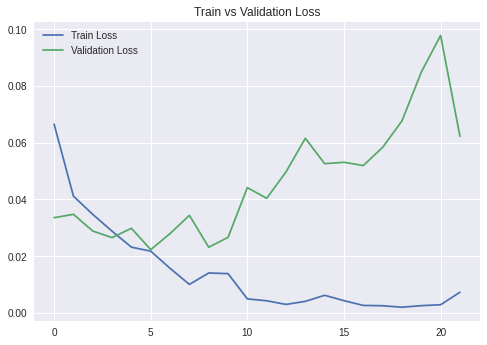

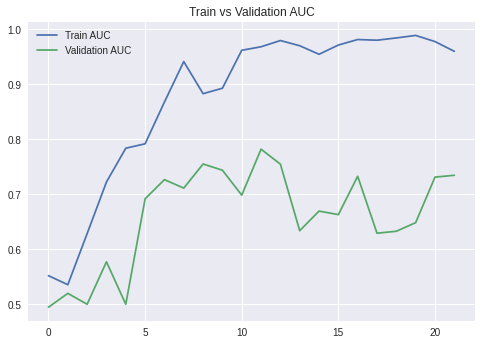


-------------------------------
Best metrics for validation set on Epoch 12:
Loss::      0.0404
AUC::       0.7821
Accuracy::  0.8543
F1::        0.6623
Precision:: 0.6711
Recall::    0.6538
Confusion Matrix:
 [[254  25]
 [ 27  51]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1713, 14)
Computing Predictions for validation set.
dataset size: (357, 14)
Computing Predictions for test set.
dataset size: (349, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running sagittal - slice:26 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_

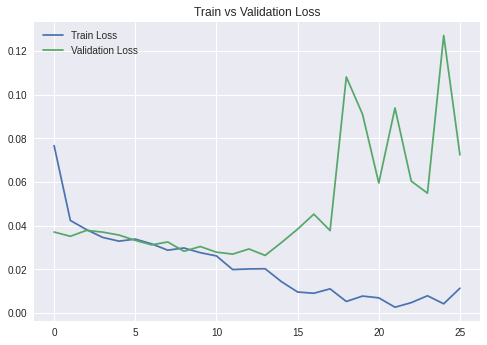

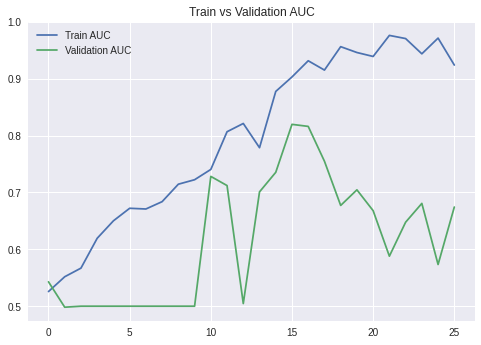


-------------------------------
Best metrics for validation set on Epoch 16:
Loss::      0.0384
AUC::       0.8198
Accuracy::  0.8627
F1::        0.7030
Precision:: 0.6667
Recall::    0.7436
Confusion Matrix:
 [[250  29]
 [ 20  58]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1713, 14)
Computing Predictions for validation set.
dataset size: (357, 14)
Computing Predictions for test set.
dataset size: (349, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:23 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_siz

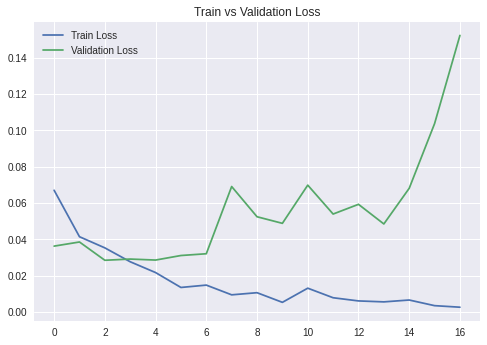

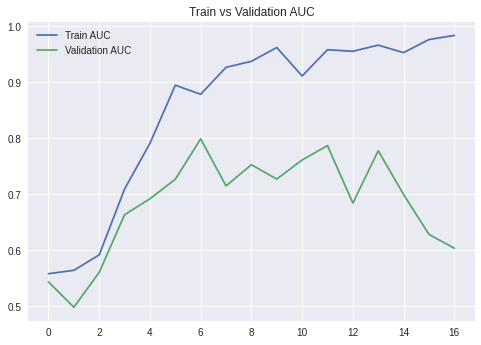


-------------------------------
Best metrics for validation set on Epoch 7:
Loss::      0.0321
AUC::       0.7988
Accuracy::  0.8515
F1::        0.6748
Precision:: 0.6471
Recall::    0.7051
Confusion Matrix:
 [[249  30]
 [ 23  55]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1713, 14)
Computing Predictions for validation set.
dataset size: (357, 14)
Computing Predictions for test set.
dataset size: (349, 14)


,SUBJECT,IMAGE_DATA_ID,ORIENTATION,SLICE,VALID_IMAGE,GROUP,MACRO_GROUP,SEX,AGE,IMAGE_PATH,ORIGINAL_IMAGE_PATH,DATASET,MAIN_SLICE,SLICE_ID,CNN_LABEL,CNN_SCORE,orientation,slice,RUN_ID
5,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,False,6.671457e-08,coronal,43,coronal43
8,941_S_4255,I261061,coronal,43,True,CN,0,M,73,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I261061_43,False,1.166640e-10,coronal,43,coronal43
11,941_S_4066,I241396,coronal,43,True,CN,0,F,79,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I241396_43,False,1.734389e-06,coronal,43,coronal43
14,153_S_5267,I384777,coronal,43,True,SMC,0,F,66,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I384777_43,False,2.870172e-09,coronal,43,coronal43
18,153_S_4372,I270067,coronal,43,True,CN,0,F,70,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I270067_43,False,4.489407e-05,coronal,43,coronal43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3711,002_S_4213,I362924,axial,23,True,CN,0,F,79,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I362924_23,False,1.074748e-22,axial,23,axial23
3723,002_S_0413,I649030,axial,23,True,CN,0,F,85,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I649030_23,False,4.240766e-23,axial,23,axial23
3724,002_S_0413,I312701,axial,23,True,CN,0,F,82,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I312701_23,False,7.795874e-26,axial,23,axial23
3725,002_S_0413,I424741,axial,23,True,CN,0,F,84,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I424741_23,False,3.710956e-25,axial,23,axial23


In [ ]:
run_experiments_for_ensemble(orientation_and_slices = [('coronal',[43]),('sagittal',[26]),('axial',[23])],
                          model='vgg19_bn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/PREDICTIONS_VGG19_BN.csv')

# Trying other experimental setups


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:43 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

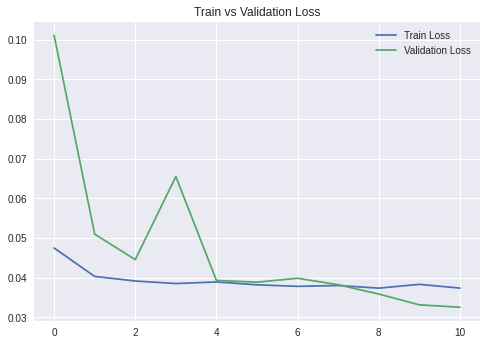

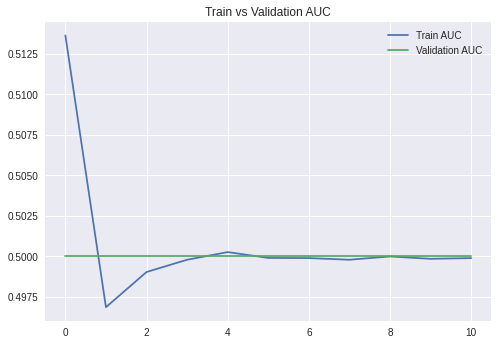


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.1010
AUC::       0.5000
Accuracy::  0.7815
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 78   0]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (6852, 15)
Computing Predictions for validation set.
dataset size: (357, 15)
Computing Predictions for test set.
dataset size: (349, 15)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running sagittal - slice:26 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(


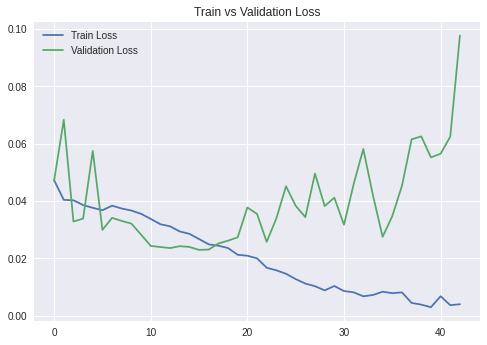

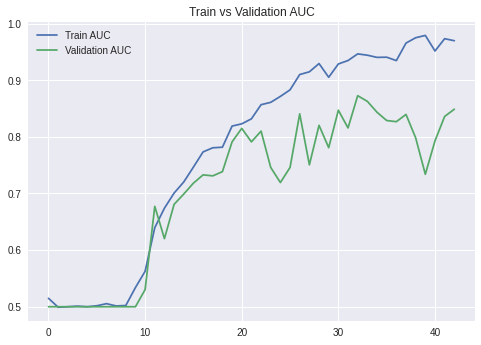


-------------------------------
Best metrics for validation set on Epoch 33:
Loss::      0.0582
AUC::       0.8726
Accuracy::  0.9020
F1::        0.7853
Precision:: 0.7529
Recall::    0.8205
Confusion Matrix:
 [[258  21]
 [ 14  64]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (6852, 15)
Computing Predictions for validation set.
dataset size: (357, 15)
Computing Predictions for test set.
dataset size: (349, 15)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:23 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
  

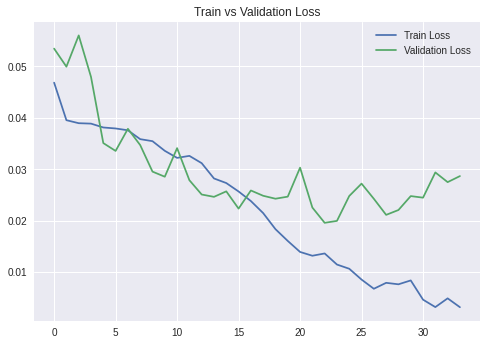

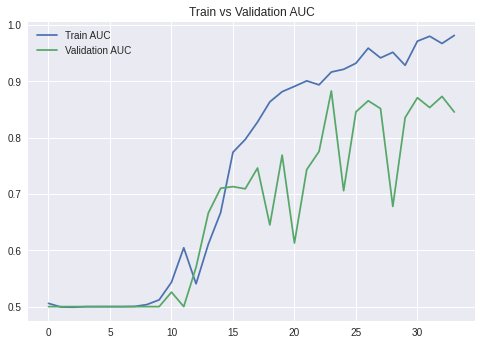


-------------------------------
Best metrics for validation set on Epoch 24:
Loss::      0.0199
AUC::       0.8826
Accuracy::  0.9104
F1::        0.8025
Precision:: 0.7738
Recall::    0.8333
Confusion Matrix:
 [[260  19]
 [ 13  65]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (6852, 15)
Computing Predictions for validation set.
dataset size: (357, 15)
Computing Predictions for test set.
dataset size: (349, 15)


,SUBJECT,IMAGE_DATA_ID,ORIENTATION,SLICE,VALID_IMAGE,GROUP,MACRO_GROUP,SEX,AGE,IMAGE_PATH,ORIGINAL_IMAGE_PATH,DATASET,MAIN_SLICE,SLICE_ID,ROTATION_ANGLE,CNN_LABEL,CNN_SCORE,orientation,slice,RUN_ID
20,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,3,False,3.255004e-01,coronal,43,coronal43
21,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,-13,False,3.231325e-01,coronal,43,coronal43
22,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,-9,False,3.234584e-01,coronal,43,coronal43
23,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,0,False,3.230444e-01,coronal,43,coronal43
32,941_S_4255,I261061,coronal,43,True,CN,0,M,73,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I261061_43,-7,False,3.243591e-01,coronal,43,coronal43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14847,002_S_4213,I362924,axial,23,True,CN,0,F,79,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I362924_23,0,False,4.209834e-06,axial,23,axial23
14895,002_S_0413,I649030,axial,23,True,CN,0,F,85,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I649030_23,0,False,1.141746e-07,axial,23,axial23
14899,002_S_0413,I312701,axial,23,True,CN,0,F,82,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I312701_23,0,False,3.779765e-08,axial,23,axial23
14903,002_S_0413,I424741,axial,23,True,CN,0,F,84,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I424741_23,0,False,7.920447e-09,axial,23,axial23


In [ ]:
run_experiments_for_ensemble(orientation_and_slices = [('coronal',[43]),('sagittal',[26]),('axial',[23])],
                          model='vgg19_bn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':3,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = None,
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/PREDICTIONS_VGG19_BN_DATA_AUG.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:43 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    

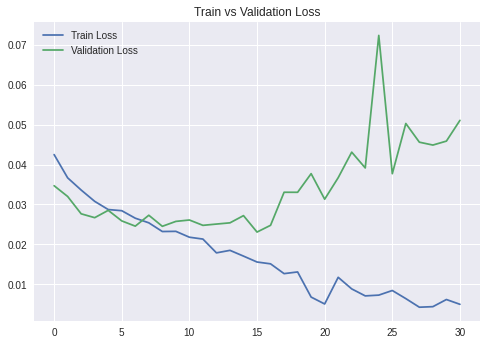

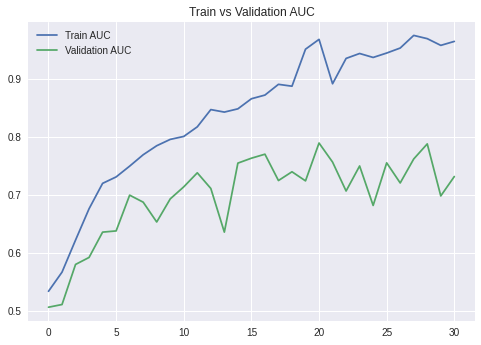


-------------------------------
Best metrics for validation set on Epoch 21:
Loss::      0.0313
AUC::       0.7890
Accuracy::  0.8796
F1::        0.6950
Precision:: 0.7778
Recall::    0.6282
Confusion Matrix:
 [[265  14]
 [ 29  49]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1713, 14)
Computing Predictions for validation set.
dataset size: (357, 14)
Computing Predictions for test set.
dataset size: (349, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running sagittal - slice:26 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(

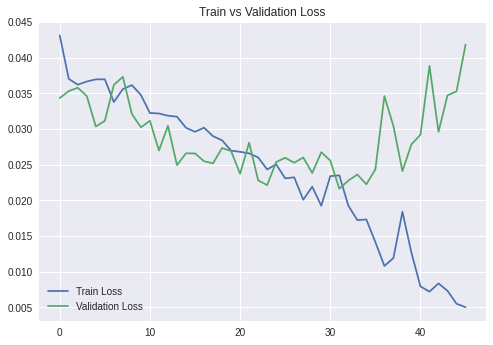

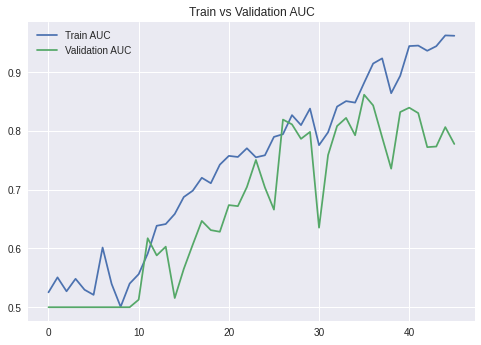


-------------------------------
Best metrics for validation set on Epoch 36:
Loss::      0.0243
AUC::       0.8619
Accuracy::  0.8852
F1::        0.7574
Precision:: 0.7033
Recall::    0.8205
Confusion Matrix:
 [[252  27]
 [ 14  64]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1713, 14)
Computing Predictions for validation set.
dataset size: (357, 14)
Computing Predictions for test set.
dataset size: (349, 14)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:23 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 

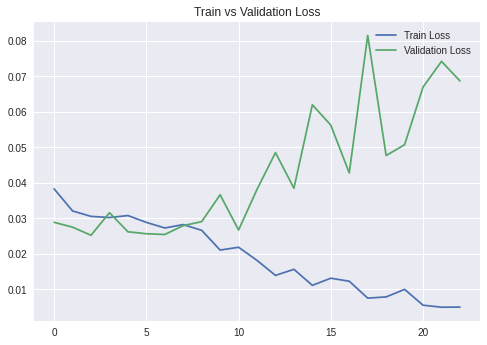

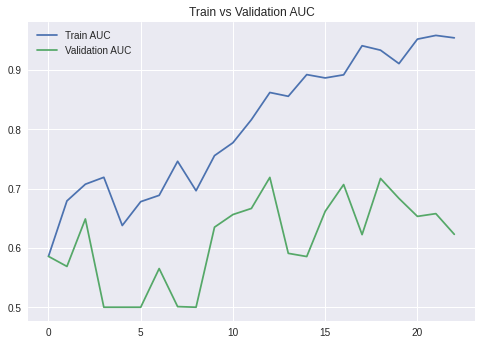


-------------------------------
Best metrics for validation set on Epoch 13:
Loss::      0.0485
AUC::       0.7188
Accuracy::  0.8347
F1::        0.5755
Precision:: 0.6557
Recall::    0.5128
Confusion Matrix:
 [[258  21]
 [ 38  40]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (1713, 14)
Computing Predictions for validation set.
dataset size: (357, 14)
Computing Predictions for test set.
dataset size: (349, 14)


,SUBJECT,IMAGE_DATA_ID,ORIENTATION,SLICE,VALID_IMAGE,GROUP,MACRO_GROUP,SEX,AGE,IMAGE_PATH,ORIGINAL_IMAGE_PATH,DATASET,MAIN_SLICE,SLICE_ID,CNN_LABEL,CNN_SCORE,orientation,slice,RUN_ID
5,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,False,5.905968e-07,coronal,43,coronal43
8,941_S_4255,I261061,coronal,43,True,CN,0,M,73,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I261061_43,False,4.770552e-03,coronal,43,coronal43
11,941_S_4066,I241396,coronal,43,True,CN,0,F,79,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I241396_43,False,1.029326e-06,coronal,43,coronal43
14,153_S_5267,I384777,coronal,43,True,SMC,0,F,66,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I384777_43,False,0.000000e+00,coronal,43,coronal43
18,153_S_4372,I270067,coronal,43,True,CN,0,F,70,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I270067_43,False,5.818920e-03,coronal,43,coronal43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3711,002_S_4213,I362924,axial,23,True,CN,0,F,79,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I362924_23,False,1.033407e-02,axial,23,axial23
3723,002_S_0413,I649030,axial,23,True,CN,0,F,85,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I649030_23,False,2.335287e-08,axial,23,axial23
3724,002_S_0413,I312701,axial,23,True,CN,0,F,82,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I312701_23,False,3.474537e-10,axial,23,axial23
3725,002_S_0413,I424741,axial,23,True,CN,0,F,84,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I424741_23,False,1.893402e-10,axial,23,axial23


In [ ]:
run_experiments_for_ensemble(orientation_and_slices = [('coronal',[43]),('sagittal',[26]),('axial',[23])],
                          model='resnet34',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':0,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = {'lr':0.001,
                             'batch_size':16,
                             'optimizer':'adam',
                             'max_epochs':100,
                             'early_stop':10,
                             'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/PREDICTIONS_RESNET34.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:43 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(

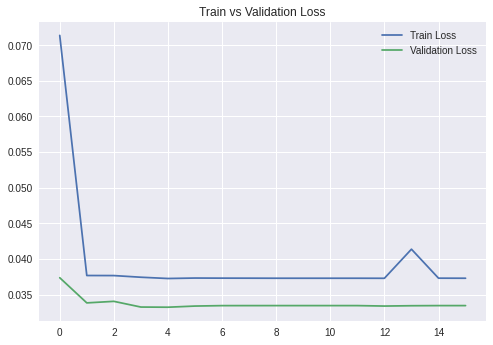

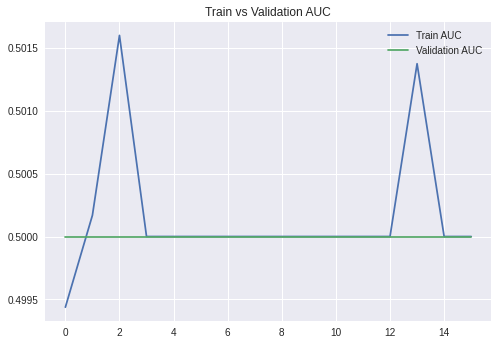


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.0374
AUC::       0.5000
Accuracy::  0.7815
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 78   0]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (6852, 15)
Computing Predictions for validation set.
dataset size: (357, 15)
Computing Predictions for test set.
dataset size: (349, 15)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running sagittal - slice:26 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64

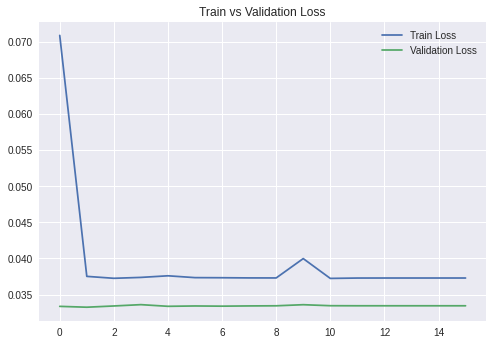

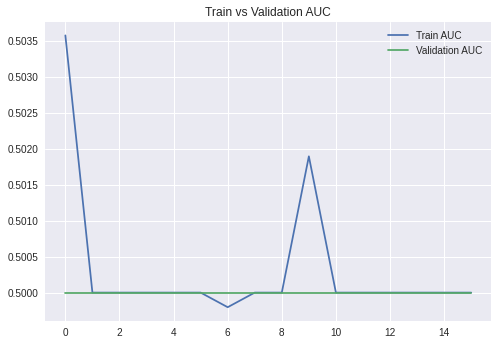


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.0334
AUC::       0.5000
Accuracy::  0.7815
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 78   0]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (6852, 15)
Computing Predictions for validation set.
dataset size: (357, 15)
Computing Predictions for test set.
dataset size: (349, 15)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:23 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
ResNet(
  (conv1): Conv2d(1, 64, k

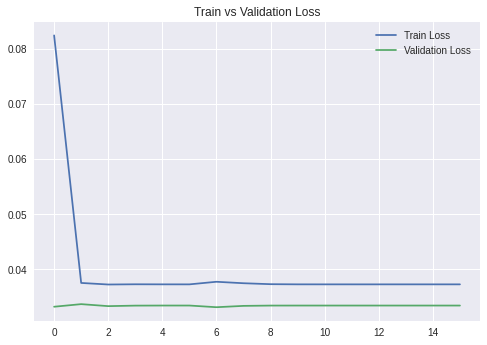

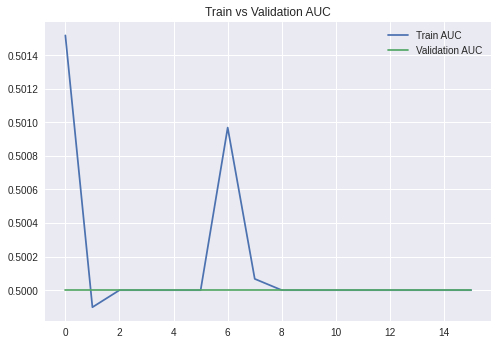


-------------------------------
Best metrics for validation set on Epoch 1:
Loss::      0.0332
AUC::       0.5000
Accuracy::  0.7815
F1::        0.0000
Precision:: 0.0000
Recall::    0.0000
Confusion Matrix:
 [[279   0]
 [ 78   0]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (6852, 15)
Computing Predictions for validation set.
dataset size: (357, 15)
Computing Predictions for test set.
dataset size: (349, 15)


,SUBJECT,IMAGE_DATA_ID,ORIENTATION,SLICE,VALID_IMAGE,GROUP,MACRO_GROUP,SEX,AGE,IMAGE_PATH,ORIGINAL_IMAGE_PATH,DATASET,MAIN_SLICE,SLICE_ID,ROTATION_ANGLE,CNN_LABEL,CNN_SCORE,orientation,slice,RUN_ID
20,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,-3,False,0.243811,coronal,43,coronal43
21,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,9,False,0.243811,coronal,43,coronal43
22,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,11,False,0.243811,coronal,43,coronal43
23,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,0,False,0.243811,coronal,43,coronal43
32,941_S_4255,I261061,coronal,43,True,CN,0,M,73,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I261061_43,-5,False,0.243811,coronal,43,coronal43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14847,002_S_4213,I362924,axial,23,True,CN,0,F,79,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I362924_23,0,False,0.243746,axial,23,axial23
14895,002_S_0413,I649030,axial,23,True,CN,0,F,85,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I649030_23,0,False,0.243746,axial,23,axial23
14899,002_S_0413,I312701,axial,23,True,CN,0,F,82,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I312701_23,0,False,0.243746,axial,23,axial23
14903,002_S_0413,I424741,axial,23,True,CN,0,F,84,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I424741_23,0,False,0.243746,axial,23,axial23


In [ ]:
run_experiments_for_ensemble(orientation_and_slices = [('coronal',[43]),('sagittal',[26]),('axial',[23])],
                          model='resnet101',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':3,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = {'lr':0.01,
                             'batch_size':16,
                             'optimizer':'adam',
                             'max_epochs':100,
                             'early_stop':15,
                             'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/PREDICTIONS_RESNET101_DATA_AUG.csv')


--------------------------------------------------------------------
--------------------------------------------------------------------
Running coronal - slice:43 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kern

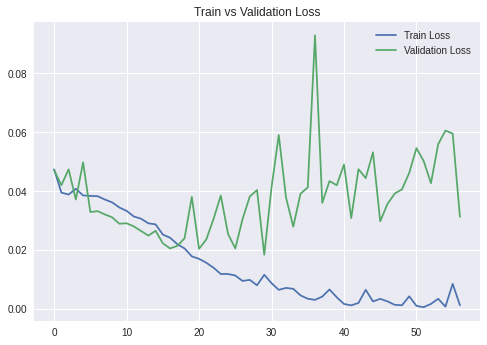

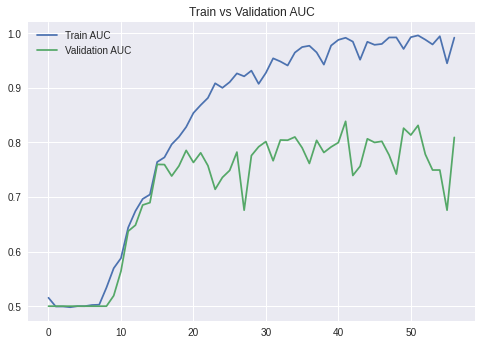


-------------------------------
Best metrics for validation set on Epoch 42:
Loss::      0.0309
AUC::       0.8388
Accuracy::  0.8852
F1::        0.7421
Precision:: 0.7284
Recall::    0.7564
Confusion Matrix:
 [[257  22]
 [ 19  59]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (6852, 15)
Computing Predictions for validation set.
dataset size: (357, 15)
Computing Predictions for test set.
dataset size: (349, 15)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running sagittal - slice:26 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss::      Train 0.0403      Validation 0.0367
AUC::       Train 0.5046      Validation 0.5000
Accuracy::  Train 0.7071      Validation 0.7815
F1::        Train 0.0738      Validation 0.0000
Precision:: Train 0.3347      Validation 0.0000
Recall::    Train 0.0415      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 2 took 34.24 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 3 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0387      Validation 0.0358
AUC::       Train 0.4995      Validation 0.5000
Accuracy::  Train 0.7179      Validation 0.7815
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 3 took 34.34 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 4 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0385      Validation 0.0370
AUC::       Train 0.5069      Validation 0.4982
Accuracy::  Train 0.7151      Validation 0.7787
F1::        Train 0.0570      Validation 0.0000
Precision:: Train 0.4155      Validation 0.0000
Recall::    Train 0.0306      Validation 0.0000
Validation Confusion Matrix:
 [[278   1]
 [ 78   0]]

Epoch 4 took 34.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 5 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0383      Validation 0.0333
AUC::       Train 0.5080      Validation 0.5000
Accuracy::  Train 0.7179      Validation 0.7815
F1::        Train 0.0529      Validation 0.0000
Precision:: Train 0.4779      Validation 0.0000
Recall::    Train 0.0280      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 5 took 34.39 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 6 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0377      Validation 0.0331
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.7186      Validation 0.7815
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 6 took 34.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 7 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0383      Validation 0.0353
AUC::       Train 0.4991      Validation 0.5000
Accuracy::  Train 0.7166      Validation 0.7815
F1::        Train 0.0031      Validation 0.0000
Precision:: Train 0.1500      Validation 0.0000
Recall::    Train 0.0016      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 7 took 34.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 8 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0378      Validation 0.0349
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.7186      Validation 0.7815
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 8 took 34.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 9 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0379      Validation 0.0324
AUC::       Train 0.5002      Validation 0.5000
Accuracy::  Train 0.7185      Validation 0.7815
F1::        Train 0.0021      Validation 0.0000
Precision:: Train 0.4000      Validation 0.0000
Recall::    Train 0.0010      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 9 took 34.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 10 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0367      Validation 0.0312
AUC::       Train 0.5002      Validation 0.5000
Accuracy::  Train 0.7186      Validation 0.7815
F1::        Train 0.0010      Validation 0.0000
Precision:: Train 0.5000      Validation 0.0000
Recall::    Train 0.0005      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 10 took 34.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 11 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0360      Validation 0.0381
AUC::       Train 0.4999      Validation 0.5000
Accuracy::  Train 0.7185      Validation 0.7815
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 11 took 34.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 12 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0359      Validation 0.0277
AUC::       Train 0.5002      Validation 0.5000
Accuracy::  Train 0.7173      Validation 0.7815
F1::        Train 0.0072      Validation 0.0000
Precision:: Train 0.3043      Validation 0.0000
Recall::    Train 0.0036      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 12 took 34.38 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 13 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0370      Validation 0.0318
AUC::       Train 0.5000      Validation 0.5000
Accuracy::  Train 0.7186      Validation 0.7815
F1::        Train 0.0000      Validation 0.0000
Precision:: Train 0.0000      Validation 0.0000
Recall::    Train 0.0000      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 13 took 34.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 14 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0354      Validation 0.0283
AUC::       Train 0.5036      Validation 0.4982
Accuracy::  Train 0.7186      Validation 0.7787
F1::        Train 0.0233      Validation 0.0000
Precision:: Train 0.5000      Validation 0.0000
Recall::    Train 0.0119      Validation 0.0000
Validation Confusion Matrix:
 [[278   1]
 [ 78   0]]

Epoch 14 took 34.39 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 15 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0366      Validation 0.0278
AUC::       Train 0.4998      Validation 0.5000
Accuracy::  Train 0.7180      Validation 0.7815
F1::        Train 0.0010      Validation 0.0000
Precision:: Train 0.1667      Validation 0.0000
Recall::    Train 0.0005      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 15 took 34.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 16 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0330      Validation 0.0220
AUC::       Train 0.5355      Validation 0.5377
Accuracy::  Train 0.7284      Validation 0.7899
F1::        Train 0.1636      Validation 0.1573
Precision:: Train 0.6128      Validation 0.6364
Recall::    Train 0.0944      Validation 0.0897
Validation Confusion Matrix:
 [[275   4]
 [ 71   7]]

Epoch 16 took 34.35 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.5377

---------------------------------------------------------------------
Running Epoch 17 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0314      Validation 0.0224
AUC::       Train 0.5204      Validation 0.5000
Accuracy::  Train 0.7177      Validation 0.7815
F1::        Train 0.1209      Validation 0.0000
Precision:: Train 0.4890      Validation 0.0000
Recall::    Train 0.0690      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 17 took 34.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 18 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0313      Validation 0.0203
AUC::       Train 0.4994      Validation 0.5000
Accuracy::  Train 0.7176      Validation 0.7815
F1::        Train 0.0010      Validation 0.0000
Precision:: Train 0.1111      Validation 0.0000
Recall::    Train 0.0005      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 18 took 34.40 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 19 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0293      Validation 0.0201
AUC::       Train 0.5005      Validation 0.5000
Accuracy::  Train 0.7185      Validation 0.7815
F1::        Train 0.0041      Validation 0.0000
Precision:: Train 0.4444      Validation 0.0000
Recall::    Train 0.0021      Validation 0.0000
Validation Confusion Matrix:
 [[279   0]
 [ 78   0]]

Epoch 19 took 34.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 20 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Loss::      Train 0.0282      Validation 0.0188
AUC::       Train 0.5365      Validation 0.8708
Accuracy::  Train 0.7259      Validation 0.8992
F1::        Train 0.1749      Validation 0.7805
Precision:: Train 0.5718      Validation 0.7442
Recall::    Train 0.1032      Validation 0.8205
Validation Confusion Matrix:
 [[257  22]
 [ 14  64]]

Epoch 20 took 34.35 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.8708

---------------------------------------------------------------------
Running Epoch 21 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0274      Validation 0.0190
AUC::       Train 0.7657      Validation 0.7790
Accuracy::  Train 0.8062      Validation 0.8711
F1::        Train 0.6616      Validation 0.6761
Precision:: Train 0.6503      Validation 0.7500
Recall::    Train 0.6732      Validation 0.6154
Validation Confusion Matrix:
 [[263  16]
 [ 30  48]]

Epoch 21 took 34.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 22 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only t

Loss::      Train 0.0269      Validation 0.0176
AUC::       Train 0.7717      Validation 0.8960
Accuracy::  Train 0.8006      Validation 0.8880
F1::        Train 0.6657      Validation 0.7802
Precision:: Train 0.6302      Validation 0.6827
Recall::    Train 0.7054      Validation 0.9103
Validation Confusion Matrix:
 [[246  33]
 [  7  71]]

Epoch 22 took 34.36 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.8960

---------------------------------------------------------------------
Running Epoch 23 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0255      Validation 0.0188
AUC::       Train 0.7868      Validation 0.7752
Accuracy::  Train 0.8147      Validation 0.8796
F1::        Train 0.6870      Validation 0.6815
Precision:: Train 0.6545      Validation 0.8070
Recall::    Train 0.7230      Validation 0.5897
Validation Confusion Matrix:
 [[268  11]
 [ 32  46]]

Epoch 23 took 34.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 24 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0238      Validation 0.0172
AUC::       Train 0.8251      Validation 0.8103
Accuracy::  Train 0.8441      Validation 0.8768
F1::        Train 0.7384      Validation 0.7105
Precision:: Train 0.6996      Validation 0.7297
Recall::    Train 0.7816      Validation 0.6923
Validation Confusion Matrix:
 [[259  20]
 [ 24  54]]

Epoch 24 took 34.34 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 25 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0231      Validation 0.0181
AUC::       Train 0.8201      Validation 0.8167
Accuracy::  Train 0.8424      Validation 0.8796
F1::        Train 0.7331      Validation 0.7190
Precision:: Train 0.7002      Validation 0.7333
Recall::    Train 0.7692      Validation 0.7051
Validation Confusion Matrix:
 [[259  20]
 [ 23  55]]

Epoch 25 took 34.38 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 26 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0223      Validation 0.0164
AUC::       Train 0.8248      Validation 0.8626
Accuracy::  Train 0.8471      Validation 0.8936
F1::        Train 0.7401      Validation 0.7683
Precision:: Train 0.7091      Validation 0.7326
Recall::    Train 0.7739      Validation 0.8077
Validation Confusion Matrix:
 [[256  23]
 [ 15  63]]

Epoch 26 took 34.39 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 27 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0217      Validation 0.0200
AUC::       Train 0.8435      Validation 0.8098
Accuracy::  Train 0.8567      Validation 0.8543
F1::        Train 0.7615      Validation 0.6867
Precision:: Train 0.7160      Validation 0.6477
Recall::    Train 0.8133      Validation 0.7308
Validation Confusion Matrix:
 [[248  31]
 [ 21  57]]

Epoch 27 took 34.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 28 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0208      Validation 0.0171
AUC::       Train 0.8539      Validation 0.9014
Accuracy::  Train 0.8635      Validation 0.8964
F1::        Train 0.7743      Validation 0.7933
Precision:: Train 0.7242      Validation 0.7030
Recall::    Train 0.8320      Validation 0.9103
Validation Confusion Matrix:
 [[249  30]
 [  7  71]]

Epoch 28 took 34.36 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.9014

---------------------------------------------------------------------
Running Epoch 29 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0209      Validation 0.0182
AUC::       Train 0.8546      Validation 0.8362
Accuracy::  Train 0.8615      Validation 0.8739
F1::        Train 0.7731      Validation 0.7273
Precision:: Train 0.7171      Validation 0.6897
Recall::    Train 0.8387      Validation 0.7692
Validation Confusion Matrix:
 [[252  27]
 [ 18  60]]

Epoch 29 took 34.34 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 30 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0200      Validation 0.0180
AUC::       Train 0.8564      Validation 0.8526
Accuracy::  Train 0.8761      Validation 0.8852
F1::        Train 0.7865      Validation 0.7515
Precision:: Train 0.7633      Validation 0.7126
Recall::    Train 0.8112      Validation 0.7949
Validation Confusion Matrix:
 [[254  25]
 [ 16  62]]

Epoch 30 took 34.38 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 31 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0186      Validation 0.0197
AUC::       Train 0.8804      Validation 0.7975
Accuracy::  Train 0.8846      Validation 0.8711
F1::        Train 0.8094      Validation 0.6933
Precision:: Train 0.7560      Validation 0.7222
Recall::    Train 0.8709      Validation 0.6667
Validation Confusion Matrix:
 [[259  20]
 [ 26  52]]

Epoch 31 took 34.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 32 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0190      Validation 0.0179
AUC::       Train 0.8669      Validation 0.8850
Accuracy::  Train 0.8767      Validation 0.8852
F1::        Train 0.7940      Validation 0.7709
Precision:: Train 0.7492      Validation 0.6832
Recall::    Train 0.8444      Validation 0.8846
Validation Confusion Matrix:
 [[247  32]
 [  9  69]]

Epoch 32 took 34.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 33 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0189      Validation 0.0185
AUC::       Train 0.8704      Validation 0.8814
Accuracy::  Train 0.8781      Validation 0.8796
F1::        Train 0.7975      Validation 0.7624
Precision:: Train 0.7490      Validation 0.6699
Recall::    Train 0.8527      Validation 0.8846
Validation Confusion Matrix:
 [[245  34]
 [  9  69]]

Epoch 33 took 34.32 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 34 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

Loss::      Train 0.0185      Validation 0.0170
AUC::       Train 0.8715      Validation 0.9021
Accuracy::  Train 0.8831      Validation 0.9048
F1::        Train 0.8027      Validation 0.8046
Precision:: Train 0.7644      Validation 0.7292
Recall::    Train 0.8449      Validation 0.8974
Validation Confusion Matrix:
 [[253  26]
 [  8  70]]

Epoch 34 took 34.33 seconds
---------------------------------------------------------------------
Best validation AUC so far: 0.9021

---------------------------------------------------------------------
Running Epoch 35 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0176      Validation 0.0178
AUC::       Train 0.8862      Validation 0.8178
Accuracy::  Train 0.8920      Validation 0.8739
F1::        Train 0.8198      Validation 0.7134
Precision:: Train 0.7727      Validation 0.7089
Recall::    Train 0.8729      Validation 0.7179
Validation Confusion Matrix:
 [[256  23]
 [ 22  56]]

Epoch 35 took 34.34 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 36 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Loss::      Train 0.0172      Validation 0.0187
AUC::       Train 0.8795      Validation 0.8796
Accuracy::  Train 0.8938      Validation 0.8768
F1::        Train 0.8177      Validation 0.7582
Precision:: Train 0.7904      Validation 0.6635
Recall::    Train 0.8470      Validation 0.8846
Validation Confusion Matrix:
 [[244  35]
 [  9  69]]

Epoch 36 took 34.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 37 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0176      Validation 0.0169
AUC::       Train 0.8800      Validation 0.8793
Accuracy::  Train 0.8913      Validation 0.8908
F1::        Train 0.8155      Validation 0.7746
Precision:: Train 0.7802      Validation 0.7053
Recall::    Train 0.8543      Validation 0.8590
Validation Confusion Matrix:
 [[251  28]
 [ 11  67]]

Epoch 37 took 34.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 38 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__d

Loss::      Train 0.0175      Validation 0.0174
AUC::       Train 0.8709      Validation 0.8960
Accuracy::  Train 0.8884      Validation 0.8880
F1::        Train 0.8073      Validation 0.7802
Precision:: Train 0.7849      Validation 0.6827
Recall::    Train 0.8309      Validation 0.9103
Validation Confusion Matrix:
 [[246  33]
 [  7  71]]

Epoch 38 took 34.38 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 39 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Loss::      Train 0.0162      Validation 0.0172
AUC::       Train 0.8932      Validation 0.8626
Accuracy::  Train 0.9057      Validation 0.8936
F1::        Train 0.8377      Validation 0.7683
Precision:: Train 0.8124      Validation 0.7326
Recall::    Train 0.8646      Validation 0.8077
Validation Confusion Matrix:
 [[256  23]
 [ 15  63]]

Epoch 39 took 34.37 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 40 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3

Loss::      Train 0.0146      Validation 0.0177
AUC::       Train 0.9010      Validation 0.8793
Accuracy::  Train 0.9126      Validation 0.8908
F1::        Train 0.8492      Validation 0.7746
Precision:: Train 0.8253      Validation 0.7053
Recall::    Train 0.8745      Validation 0.8590
Validation Confusion Matrix:
 [[251  28]
 [ 11  67]]

Epoch 40 took 34.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 41 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0149      Validation 0.0174
AUC::       Train 0.8944      Validation 0.8580
Accuracy::  Train 0.9101      Validation 0.8936
F1::        Train 0.8431      Validation 0.7654
Precision:: Train 0.8283      Validation 0.7381
Recall::    Train 0.8584      Validation 0.7949
Validation Confusion Matrix:
 [[257  22]
 [ 16  62]]

Epoch 41 took 34.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 42 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0138      Validation 0.0201
AUC::       Train 0.9097      Validation 0.8678
Accuracy::  Train 0.9158      Validation 0.8655
F1::        Train 0.8569      Validation 0.7391
Precision:: Train 0.8212      Validation 0.6415
Recall::    Train 0.8957      Validation 0.8718
Validation Confusion Matrix:
 [[241  38]
 [ 10  68]]

Epoch 42 took 34.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 43 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: 

Loss::      Train 0.0143      Validation 0.0241
AUC::       Train 0.9096      Validation 0.8278
Accuracy::  Train 0.9181      Validation 0.8824
F1::        Train 0.8595      Validation 0.7308
Precision:: Train 0.8310      Validation 0.7308
Recall::    Train 0.8900      Validation 0.7308
Validation Confusion Matrix:
 [[258  21]
 [ 21  57]]

Epoch 43 took 34.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 44 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Loss::      Train 0.0135      Validation 0.0211
AUC::       Train 0.9096      Validation 0.8444
Accuracy::  Train 0.9209      Validation 0.8796
F1::        Train 0.8628      Validation 0.7394
Precision:: Train 0.8427      Validation 0.7011
Recall::    Train 0.8838      Validation 0.7821
Validation Confusion Matrix:
 [[253  26]
 [ 17  61]]

Epoch 44 took 34.35 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 45 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0169      Validation 0.0176
AUC::       Train 0.8850      Validation 0.8036
Accuracy::  Train 0.8987      Validation 0.8880
F1::        Train 0.8259      Validation 0.7183
Precision:: Train 0.7998      Validation 0.7969
Recall::    Train 0.8537      Validation 0.6538
Validation Confusion Matrix:
 [[266  13]
 [ 27  51]]

Epoch 45 took 34.33 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 46 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0121      Validation 0.0186
AUC::       Train 0.9135      Validation 0.8655
Accuracy::  Train 0.9276      Validation 0.8908
F1::        Train 0.8726      Validation 0.7665
Precision:: Train 0.8642      Validation 0.7191
Recall::    Train 0.8812      Validation 0.8205
Validation Confusion Matrix:
 [[254  25]
 [ 14  64]]

Epoch 46 took 34.32 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 47 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0143      Validation 0.0194
AUC::       Train 0.8952      Validation 0.8278
Accuracy::  Train 0.9152      Validation 0.8824
F1::        Train 0.8494      Validation 0.7308
Precision:: Train 0.8491      Validation 0.7308
Recall::    Train 0.8496      Validation 0.7308
Validation Confusion Matrix:
 [[258  21]
 [ 21  57]]

Epoch 47 took 34.29 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 48 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0127      Validation 0.0205
AUC::       Train 0.9150      Validation 0.8121
Accuracy::  Train 0.9282      Validation 0.8796
F1::        Train 0.8740      Validation 0.7152
Precision:: Train 0.8634      Validation 0.7397
Recall::    Train 0.8849      Validation 0.6923
Validation Confusion Matrix:
 [[260  19]
 [ 24  54]]

Epoch 48 took 34.36 seconds
---------------------------------------------------------------------

---------------------------------------------------------------------
Running Epoch 49 of  100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f260dc1d170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loss::      Train 0.0115      Validation 0.0214
AUC::       Train 0.9346      Validation 0.8395
Accuracy::  Train 0.9396      Validation 0.8936
F1::        Train 0.8958      Validation 0.7532
Precision:: Train 0.8700      Validation 0.7632
Recall::    Train 0.9232      Validation 0.7436
Validation Confusion Matrix:
 [[261  18]
 [ 20  58]]

Epoch 49 took 34.34 seconds
---------------------------------------------------------------------

Exiting training... It hit early stopping criteria of: 15 epochs
Saving model at: 


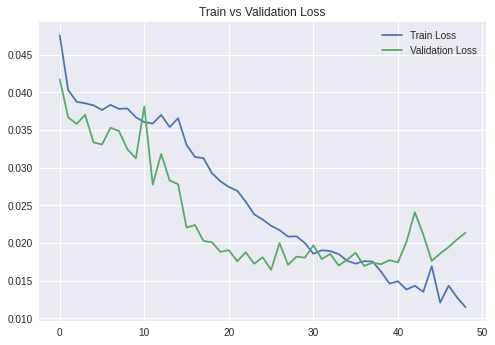

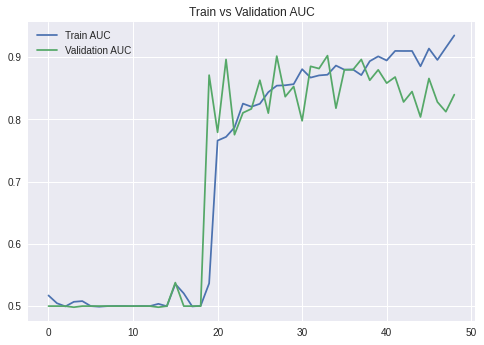


-------------------------------
Best metrics for validation set on Epoch 34:
Loss::      0.0170
AUC::       0.9021
Accuracy::  0.9048
F1::        0.8046
Precision:: 0.7292
Recall::    0.8974
Confusion Matrix:
 [[253  26]
 [  8  70]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (6852, 15)
Computing Predictions for validation set.
dataset size: (357, 15)
Computing Predictions for test set.
dataset size: (349, 15)

--------------------------------------------------------------------
--------------------------------------------------------------------
Running axial - slice:23 with no data augmentation.
--------------------------------------------------------------------
--------------------------------------------------------------------

Creating augmented samples...
Creating 2d image rotations...
Creating final reference file for prepared images...
Loading untrained model...
VGG(
  (features): Sequential(
  

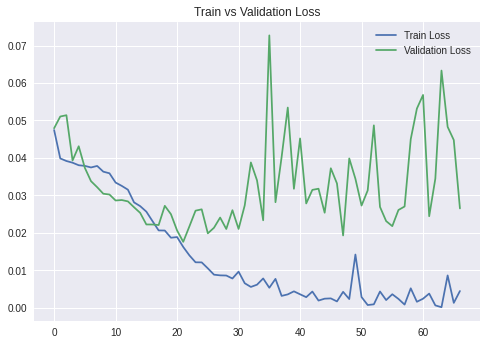

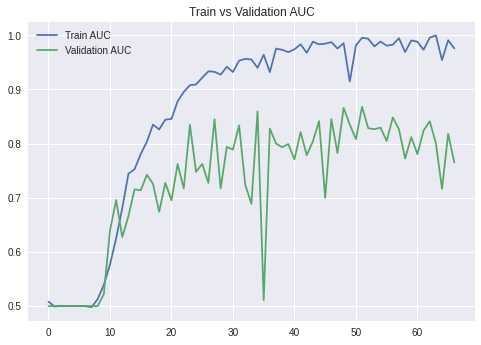


-------------------------------
Best metrics for validation set on Epoch 52:
Loss::      0.0313
AUC::       0.8677
Accuracy::  0.9160
F1::        0.8026
Precision:: 0.8243
Recall::    0.7821
Confusion Matrix:
 [[266  13]
 [ 17  61]]
-------------------------------

Saving predictions from trained model...
Computing Predictions for train set.
dataset size: (6852, 15)
Computing Predictions for validation set.
dataset size: (357, 15)
Computing Predictions for test set.
dataset size: (349, 15)


,SUBJECT,IMAGE_DATA_ID,ORIENTATION,SLICE,VALID_IMAGE,GROUP,MACRO_GROUP,SEX,AGE,IMAGE_PATH,ORIGINAL_IMAGE_PATH,DATASET,MAIN_SLICE,SLICE_ID,ROTATION_ANGLE,CNN_LABEL,CNN_SCORE,orientation,slice,RUN_ID
20,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,-13,False,8.777222e-03,coronal,43,coronal43
21,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,5,False,3.815421e-06,coronal,43,coronal43
22,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,-11,False,2.969939e-04,coronal,43,coronal43
23,941_S_4376,I300498,coronal,43,True,CN,0,F,76,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I300498_43,0,False,8.087781e-07,coronal,43,coronal43
32,941_S_4255,I261061,coronal,43,True,CN,0,M,73,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,train,43,I261061_43,-7,False,6.923562e-07,coronal,43,coronal43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14847,002_S_4213,I362924,axial,23,True,CN,0,F,79,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I362924_23,0,False,1.400705e-05,axial,23,axial23
14895,002_S_0413,I649030,axial,23,True,CN,0,F,85,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I649030_23,0,False,4.823756e-05,axial,23,axial23
14899,002_S_0413,I312701,axial,23,True,CN,0,F,82,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I312701_23,0,False,3.190030e-05,axial,23,axial23
14903,002_S_0413,I424741,axial,23,True,CN,0,F,84,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,/content/gdrive/MyDrive/Lucas_Thimoteo/data/mr...,test,23,I424741_23,0,False,5.977860e-05,axial,23,axial23


In [ ]:
run_experiments_for_ensemble(orientation_and_slices = [('coronal',[43]),('sagittal',[26]),('axial',[23])],
                          model='vgg19_bn',
                          classes=['AD','CN'],
                          mri_config = {
                            'num_samples':0,
                            'num_rotations':3,
                            'sampling_range':3,
                            'mri_reference':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/reference/PROCESSED_MRI_REFERENCE_ALL_ORIENTATIONS_20211012_2041.csv',
                            'output_path':'/content/gdrive/MyDrive/Lucas_Thimoteo/data/mri/experiments/',
                            },
                          additional_experiment_params = {
                             'lr':0.0001,
                             'batch_size':16,
                             'optimizer':'adam',
                             'max_epochs':100,
                             'early_stop':15,
                             'prediction_threshold':0.5},
                          save_path = '/content/gdrive/MyDrive/Lucas_Thimoteo/data/PREDICTIONS_VGG19_BN_DATA_AUG_LR_0001.csv')